In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00


In [9]:
! pip install transformers

# Emotion Classification Project Implementation Guide

## 1. Environment Setup

- Import essential libraries for sequence modeling

- Tokenizer and pad_sequences for text preprocessing

- RNN variants from Keras layers

- load_dataset for Hugging Face datasets integration

- matplotlib for visualization

In [10]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

### Data Loading

In [11]:
emotions = load_dataset("emotion")
emotions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [12]:
# sample data
emotions['train']['text'][0]

'i didnt feel humiliated'

## Text Preprocessing

- Create word-level vocabulary with 10,000 words capacity

- Convert text to numerical indices

- Dynamic padding using 95th percentile of sequence lengths

- Post-padding to handle variable length sequences

In [13]:
## Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(emotions['train']['text'])

#get sequences
train_sequences = tokenizer.texts_to_sequences(emotions['train']['text'])
test_sequences = tokenizer.texts_to_sequences(emotions['test']['text'])

# get max length for padding
lengths = [len(seq) for seq in train_sequences]
max_length = max(lengths)

# pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


# Extract labels
train_labels = emotions['train']['label']
test_labels = emotions['test']['label']

## Dataset Preparation

- Create TensorFlow Dataset objects

- Shuffle and batch training data

- Prefetch for optimized pipeline

- Maintain same batch size for comparison

In [14]:
BATCH_SIZE = 64

# Prepare training data - wrap features and labels in a TUPLE
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Model Building (RNN/LSTM/GRU)

In [15]:
# def build_model(model_type='lstm'):
#   model=Sequential([
#       Embedding(10000,32,input_length=max_length),
#       Bidirectional(LSTM(64 , return_sequences=True)) if model_type=='lstm' else
#       Bidirectional(GRU(64 , return_sequences=True)) if model_type=='gru' else
#       Bidirectional(SimpleRNN(64 , return_sequences=True)),
#       Bidirectional(LSTM(64)),
#       tf.keras.layers.GlobalAveragePooling1D(),

#       Dense(64, activation='relu'),
#       Dense(6, activation='softmax')

#   ])
#   model.compile(
#         optimizer=tf.keras.optimizers.Adam(1e-3),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#   return model


# 1. Define Models Properly
def build_model(model_type):
    model = Sequential()
    model.add(Embedding(10000, 128))
    if model_type == 'lstm':
        model.add(LSTM(64))
    elif model_type == 'gru':
        model.add(GRU(64))
    elif model_type == 'rnn':
        model.add(SimpleRNN(64))
    else:
        raise ValueError("Invalid model type!")
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model  # <-- Explicit return

# 2. Initialize Models
lstm_model = build_model('lstm')
gru_model = build_model('gru')
rnn_model = build_model('rnn')

In [16]:
lstm_model = build_model('lstm')
gru_model = build_model('gru')
rnn_model = build_model('rnn')

### Training & Evaluation|

In [17]:

# 3. Create Models Dictionary
models = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'RNN': rnn_model
}

# 4. Train Models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

Training LSTM...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3299 - loss: 1.5988 - val_accuracy: 0.2900 - val_loss: 1.5648
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3249 - loss: 1.5821 - val_accuracy: 0.3475 - val_loss: 1.5646
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3398 - loss: 1.5842 - val_accuracy: 0.3475 - val_loss: 1.5628
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3387 - loss: 1.5823 - val_accuracy: 0.2905 - val_loss: 1.5633
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3341 - loss: 1.5806 - val_accuracy: 0.3475 - val_loss: 1.5605
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3408 - loss: 1.5810 - val_accuracy: 0.3465 - val_loss: 1.5607
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3389 - loss: 1.5742 - val_accuracy: 0.3525 - val_loss: 1.5405
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3567 - loss: 1.532

In [18]:
# 1. Define Models Properly
def build_model(model_type):
    model = Sequential()
    model.add(Embedding(10000, 128))
    if model_type == 'lstm':
        model.add(LSTM(64))
    elif model_type == 'gru':
        model.add(GRU(64))
    elif model_type == 'rnn':
        model.add(SimpleRNN(64))
    else:
        raise ValueError("Invalid model type!")
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model  # <-- Explicit return

# 2. Initialize Models
lstm_model = build_model('lstm')
gru_model = build_model('gru')
rnn_model = build_model('rnn')

# 3. Create Models Dictionary
models = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'RNN': rnn_model
}

# 4. Train Models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

Training LSTM...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3184 - loss: 1.5996 - val_accuracy: 0.3475 - val_loss: 1.5681
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3390 - loss: 1.5821 - val_accuracy: 0.3475 - val_loss: 1.5598
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3412 - loss: 1.5834 - val_accuracy: 0.3475 - val_loss: 1.5660
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3397 - loss: 1.5812 - val_accuracy: 0.3475 - val_loss: 1.5604
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3426 - loss: 1.5793 - val_accuracy: 0.3475 - val_loss: 1.5593
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3403 - loss: 1.5804 - val_accuracy: 0.3420 - val_loss: 1.5681
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3402 - loss: 1.5781 - val_accuracy: 0.3475 - val_loss: 1.5609
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3390 - loss: 1.5629 -

Training LSTM...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3365 - loss: 1.5835 - val_accuracy: 0.3475 - val_loss: 1.5640
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3418 - loss: 1.5800 - val_accuracy: 0.3475 - val_loss: 1.5599
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3378 - loss: 1.5834 - val_accuracy: 0.3475 - val_loss: 1.5603
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3385 - loss: 1.5794 - val_accuracy: 0.3475 - val_loss: 1.5601
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3394 - loss: 1.5808 - val_accuracy: 0.3475 - val_loss: 1.5605
Training GRU...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9851 - loss: 0.0411 - val_accuracy: 0.9195 - val_loss: 0.2576
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9880 - loss: 0.0351 - val_accuracy: 0.9185 - val_loss: 0.2726
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9886

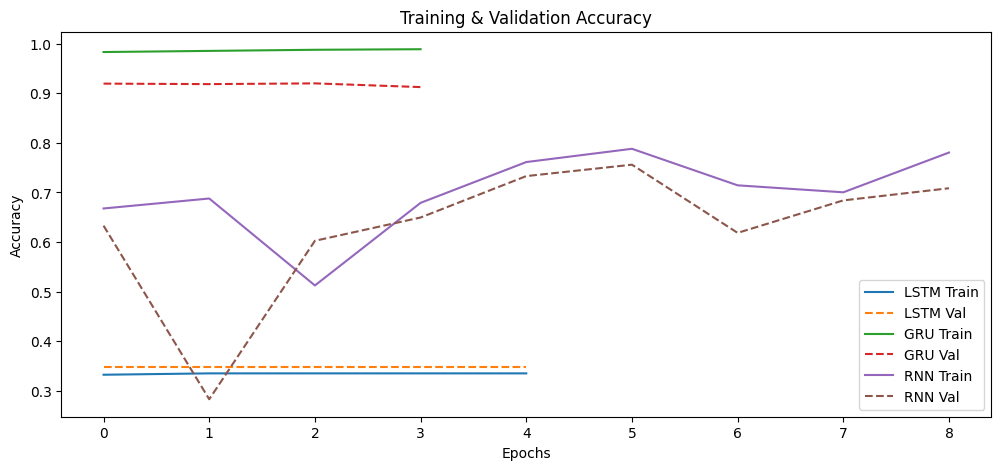

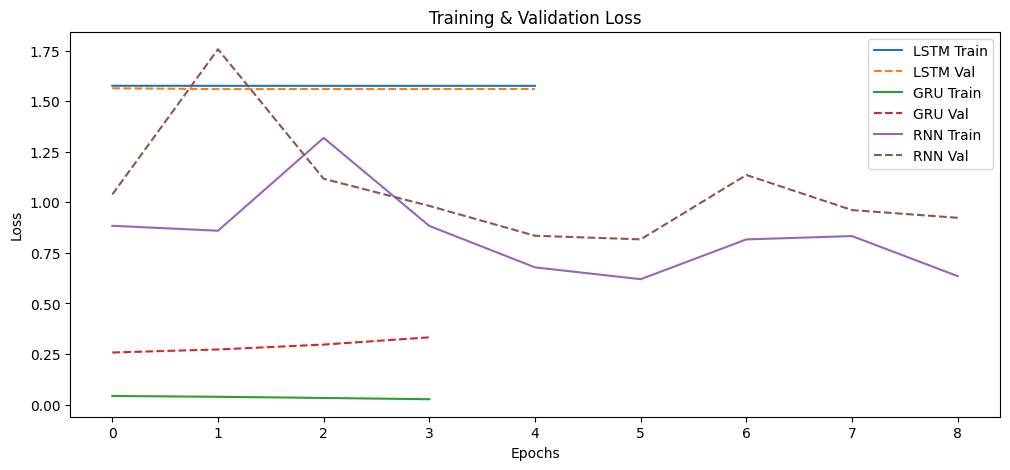

In [19]:
import matplotlib.pyplot as plt

# Define a dictionary to store history objects
histories = {}

# Train Models & Store Histories
for model_name, model in models.items():
    print(f"Training {model_name}...")
    histories[model_name] = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

# Plot Training Accuracy & Validation Accuracy
plt.figure(figsize=(12, 5))
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train')
    plt.plot(history.history['val_accuracy'], linestyle='dashed', label=f'{model_name} Val')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# Plot Training Loss & Validation Loss
plt.figure(figsize=(12, 5))
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train')
    plt.plot(history.history['val_loss'], linestyle='dashed', label=f'{model_name} Val')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [20]:
! pip install datasets

In [21]:
! pip install transformers

In [22]:
import tensorflow as tf
from transformers import TFAutoModel ,AutoTokenizer
from datasets import load_dataset

### Load emotions Dataset

In [23]:
emotions = load_dataset("SetFit/emotion")

README.md:   0%|          | 0.00/194 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/276k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/279k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Initialize model and tokenizer

In [24]:
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

### create tokenize function

In [26]:
def tokenize (batch):
    return tokenizer(batch["text"] ,padding=True ,truncation=True)


### tokenize and encode emotions dataset

In [27]:
encoded_emotions = emotions.map(tokenize, batched=True ,batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [28]:
encoded_emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Convert Data into TF format

In [29]:
# setting 'input_ids', 'attention_mask', 'token_type_ids', and 'label'
# to the tensorflow format. Now if you access this dataset you will get these
# columns in `tf.Tensor` format

encoded_emotions.set_format('tf',
                            columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])


ABTCH_SIZE =64

def order (inp):
    """
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.

    """

    return {
        'input_ids': inp['input_ids'],
        'attention_mask': inp['attention_mask'],
        'token_type_ids': inp['token_type_ids']
    }, inp['label']

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(encoded_emotions['train'][:])

# set batch_size and shuffle
train_dataset = train_dataset.shuffle(1000).batch(ABTCH_SIZE)

# map the `order` function
train_dataset=train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

#same thing to test_dataset
test_dataset = tf.data.Dataset.from_tensor_slices(encoded_emotions['test'][:])
test_dataset = test_dataset.batch(ABTCH_SIZE)
test_dataset=test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[ 101, 1045, 2001, ...,    0,    0,    0],
       [ 101, 1045, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0],
       ...,
       [ 101, 2043, 1045, ...,    0,    0,    0],
       [ 101, 1045, 4299, ...,    0,    0,    0],
       [ 101, 1045, 2134, ...,    0,    0,    0]])>, 'attention_mask': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>} 

 tf.Tensor(
[5 3 0 0 3 1 2 1 1 2 0 2 0 0 1 3 4 0 1 3 0 1 2 4 0 4 1 0 2 2 1 

### Create Bert Classifier

In [31]:
class BertForClassification(tf.keras.Model):
  def __init__(self,model,num_classes):
    super().__init__()
    # load modeel
    self.bert = model
    # output layer
    self.fc= tf.keras.layers.Dense(num_classes , activation="softmax")

  def call(self,inputs):
    x= self.bert(inputs)[1]
    return self.fc(x)



### compile

In [32]:
classifier = BertForClassification(model,6)

classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=['accuracy'])

## fit model

In [33]:
history = classifier.fit(train_dataset,epochs=3)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 303ms/step - accuracy: 0.1859 - loss: 1.8176
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.2999 - loss: 1.6416
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.3125 - loss: 1.6107


### Evaluate model

In [34]:
classifier.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step - accuracy: 0.3217 - loss: 1.5939


[1.5838260650634766, 0.32350000739097595]

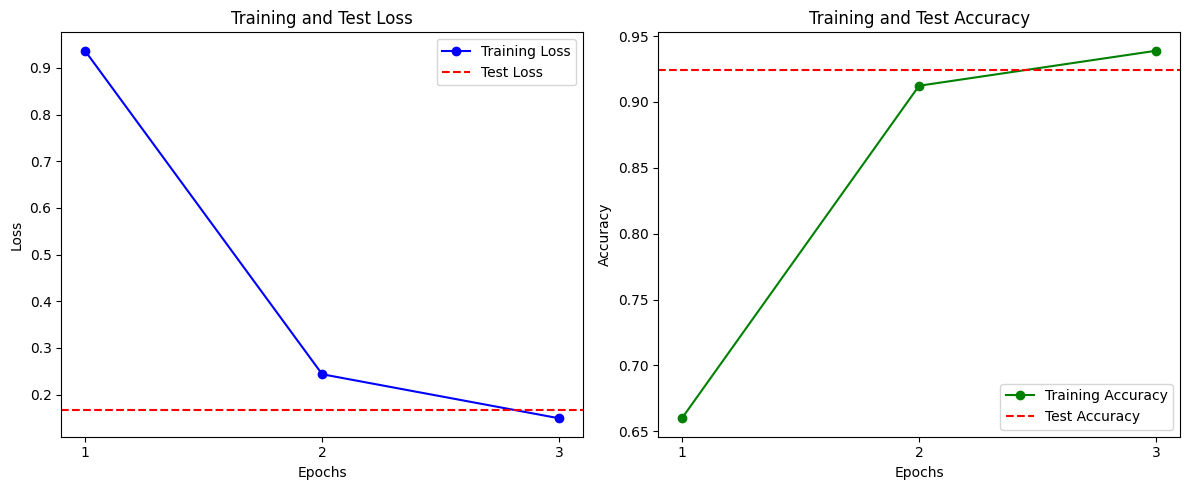

In [35]:
import matplotlib.pyplot as plt

# Training data
epochs = [1, 2, 3]
train_loss = [0.9370, 0.2436, 0.1491]
train_accuracy = [0.6598, 0.9123, 0.9389]

# Test data
test_loss = 0.1678
test_accuracy = 0.9240

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.axhline(test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'go-', label='Training Accuracy')
plt.axhline(test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Save Hugging Face Transformer Model (BERT)
model.save_pretrained("./bert_emotion_model.h5")